We'll work with the MSRP variable, and we'll transform it to a classification task.

For the rest of the homework, you'll need to use only these columns:

Make,
Model,
Year,
Engine HP,
Engine Cylinders,
Transmission Type,
Vehicle Style,
highway MPG,
city mpg
MSRP

Data preparation

*Keep only the columns above

*Lowercase the column names and replace spaces with underscores

*Fill the missing values with 0

*Make the price binary (1 if above the average, 0 otherwise) - this will be our target variable above_average

*Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution. Use train_test_split function for that with random_state=1

In [51]:
import pandas as pd
from sklearn.model_selection import train_test_split

columns_to_keep = ["Make", "Model", "Year", "Engine HP", "Engine Cylinders", 
                   "Transmission Type", "Vehicle Style", "highway MPG", 
                   "city mpg", "MSRP"]

df = pd.read_csv('data.csv', usecols=columns_to_keep)
df.columns = df.columns.str.lower().str.replace(" ", "_")

df = df.fillna(0)

average_msrp = df['msrp'].mean()
df['above_average'] = (df['msrp'] > average_msrp).astype(int)
df.drop(columns=['msrp'], inplace=True)  # Removing the original 'msrp' column

categorical_vars = list(df.dtypes[df.dtypes == 'object'].index)
for c in categorical_vars:
    df[c] = df[c].str.lower().str.replace(' ', '_')

df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)



In [47]:
X_train = df_train.reset_index(drop=True)
X_val = df_val.reset_index(drop=True)
X_test = df_test.reset_index(drop=True)

y_train = df_train.above_average.values
y_val = df_val.above_average.values
y_test = df_test.above_average.values

del X_train['above_average']
del X_val['above_average']
del X_test['above_average']

Question 1: ROC AUC feature importance

In [48]:
from sklearn.metrics import roc_auc_score

variables = ["engine_hp", "engine_cylinders", "highway_mpg", "city_mpg"]
auc_values = {}

for var in variables:
    auc = roc_auc_score(y_train, X_train[var])
    
    if auc < 0.5:
        auc = roc_auc_score(y_train, -X_train[var])
        
    auc_values[var] = auc

max_auc_var = max(auc_values, key=auc_values.get)

print(auc_values)
print(f"The variable with the highest AUC is: {max_auc_var}")


{'engine_hp': 0.9171031265539011, 'engine_cylinders': 0.766116490165669, 'highway_mpg': 0.6330587871772013, 'city_mpg': 0.6734244643245233}
The variable with the highest AUC is: engine_hp


In [49]:
X_train

,make,model,year,engine_hp,engine_cylinders,transmission_type,vehicle_style,highway_mpg,city_mpg
0,toyota,highlander_hybrid,2016,280.0,6.0,automatic,4dr_suv,28,27
1,chevrolet,impala_limited,2014,300.0,6.0,automatic,sedan,30,18
2,buick,regal,2016,259.0,4.0,automatic,sedan,27,19
3,volkswagen,cc,2015,280.0,6.0,automated_manual,sedan,25,17
4,dodge,grand_caravan,2016,283.0,6.0,automatic,passenger_minivan,25,17
...,...,...,...,...,...,...,...,...,...
7143,subaru,impreza,2015,148.0,4.0,manual,4dr_hatchback,33,24
7144,infiniti,qx50,2016,325.0,6.0,automatic,4dr_suv,24,17
7145,honda,fit,2017,130.0,4.0,automatic,4dr_hatchback,37,32
7146,audi,200,1991,162.0,5.0,automatic,sedan,20,16


Question 2: Training the model

In [50]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(X_train.to_dict(orient='records'))
X_val = dv.transform(X_val.to_dict(orient='records'))

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

y_pred_val = model.predict_proba(X_val)[:, 1]
auc_val = roc_auc_score(y_val, y_pred_val)

print(f"AUC on validation dataset: {round(auc_val, 3)}")


AUC on validation dataset: 0.977


Question 3: Precision and Recall

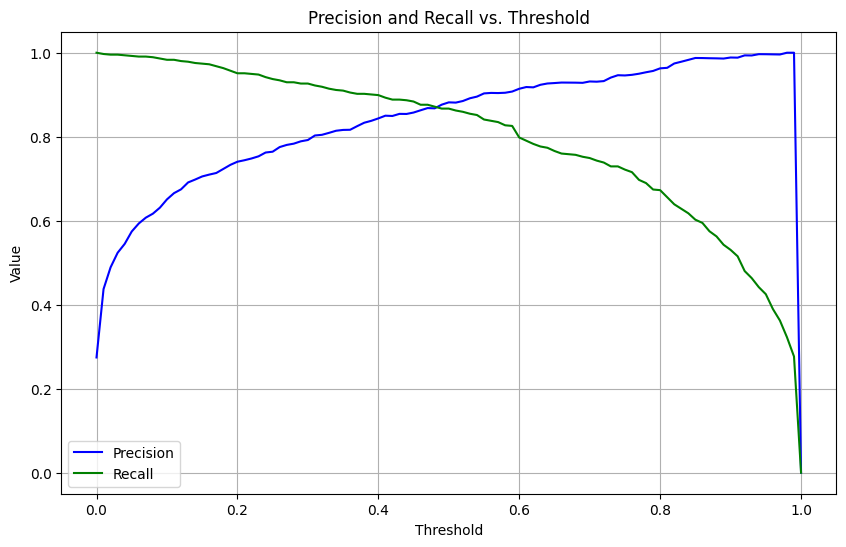

Precision and recall intersect at threshold: 0.47


In [37]:
import numpy as np
import matplotlib.pyplot as plt

thresholds = np.arange(0.0, 1.01, 0.01) 

y_pred_probs = y_pred_val.copy()

precisions = []
recalls = []

# For each threshold, compute precision and recall
for threshold in thresholds:
    y_pred = (y_pred_probs > threshold).astype(int)
    TP = np.sum((y_pred == 1) & (y_val == 1))
    FP = np.sum((y_pred == 1) & (y_val == 0))
    FN = np.sum((y_pred == 0) & (y_val == 1))
    
    precision = TP / (TP + FP) if TP + FP > 0 else 0
    recall = TP / (TP + FN) if TP + FN > 0 else 0
    
    precisions.append(precision)
    recalls.append(recall)

plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions, label='Precision', color='blue')
plt.plot(thresholds, recalls, label='Recall', color='green')
plt.xlabel('Threshold')
plt.ylabel('Value')
plt.title('Precision and Recall vs. Threshold')
plt.legend()
plt.grid(True)
plt.show()

# Find the threshold where precision and recall intersect
intersect_threshold_idx = np.where(np.abs(np.array(precisions) - np.array(recalls)) < 0.01)[0]
intersect_threshold = thresholds[intersect_threshold_idx][0]
print(f"Precision and recall intersect at threshold: {intersect_threshold:.2f}")


Question 4: F1 score

In [40]:
# Calculate F1 for each threshold
f1_scores = []
for p, r in zip(precisions, recalls):
    if p + r != 0:
        f1 = 2 * (p * r) / (p + r)
    else:
        f1 = 0
    f1_scores.append(f1)

max_f1_idx = np.argmax(f1_scores)
max_f1_threshold = thresholds[max_f1_idx]

print(f"Maximal F1 is achieved at threshold: {max_f1_threshold:.2f}")


Maximal F1 is achieved at threshold: 0.50


Question 5: 5-Fold CV

In [57]:
from sklearn.model_selection import KFold
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

def train(df_train, y_train, C=1.0):
    dicts = df_train.to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

def predict(df, dv, model):
    dicts = df.to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

kfold = KFold(n_splits=5, shuffle=True, random_state=1)

# Store the AUC scores for each fold
auc_scores = []

for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = df_train.above_average.values
    y_val = df_val.above_average.values

    del df_train['above_average']
    del df_val['above_average']

    dv, model = train(df_train, y_train, C=1.0)
    y_pred = predict(df_val, dv, model)

    auc = roc_auc_score(y_val, y_pred)
    print(auc)
    auc_scores.append(auc)

# Compute the standard deviation of AUC scores
std_dev = np.std(auc_scores)

print(f"Standard deviation of AUC scores across 5 folds: {std_dev:.3f}")
    

0.9784877485355993
0.9822604675199014
0.9777410629635827
0.9795549606826167
0.9776806526806527
Standard deviation of AUC scores across 5 folds: 0.002


Question 6: Hyperparemeter Tuning

In [66]:

for C in [0.01, 0.1, 0.5, 10]:

    kfold = KFold(n_splits=5, shuffle=True, random_state=1)

    auc_scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.above_average.values
        y_val = df_val.above_average.values

        del df_train['above_average']
        del df_val['above_average']

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        auc_scores.append(auc)
    print('C=%s %.3f +- %.3f' % (C, np.mean(auc_scores), np.std(auc_scores)))

C=0.01 0.952 +- 0.002
C=0.1 0.972 +- 0.002
C=0.5 0.980 +- 0.003
C=10 0.984 +- 0.003
